# Capstone project: Forecast daily views of a blog website

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    "#000072", # blue (for historical data)
    "#80c21d", # green (for actual data)
    "#924eae", # purple
    "#ff0000", # red
    "#ff9100", # orange
])

## Explore the data

In [5]:
df = pd.read_csv("../data/blog_traffic_daily.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


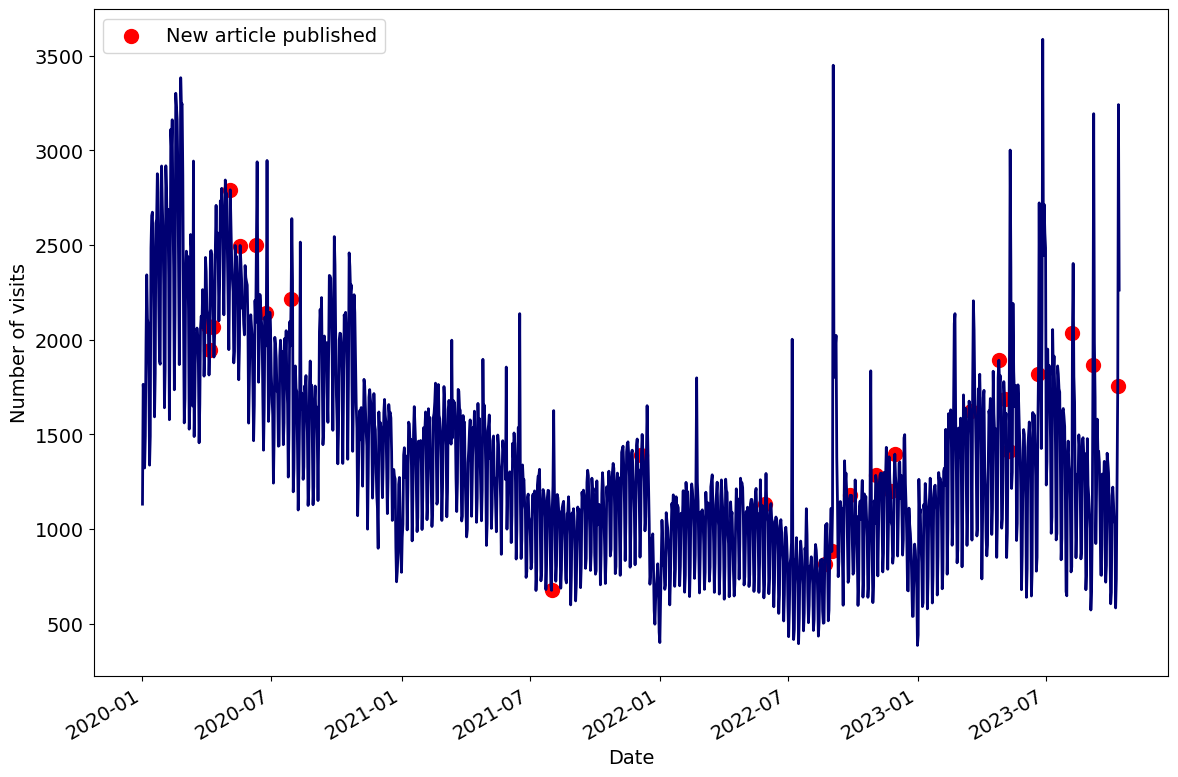

In [11]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', s=100, color='#ff0000', label='New article published')
ax.set_xlabel('Date')
ax.set_ylabel('Number of visits')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH010_F01_peixeiro2.png", dpi=300)
plt.savefig('figures/CH10_F01_peixeiro2.pdf', format='pdf', bbox_inches='tight')

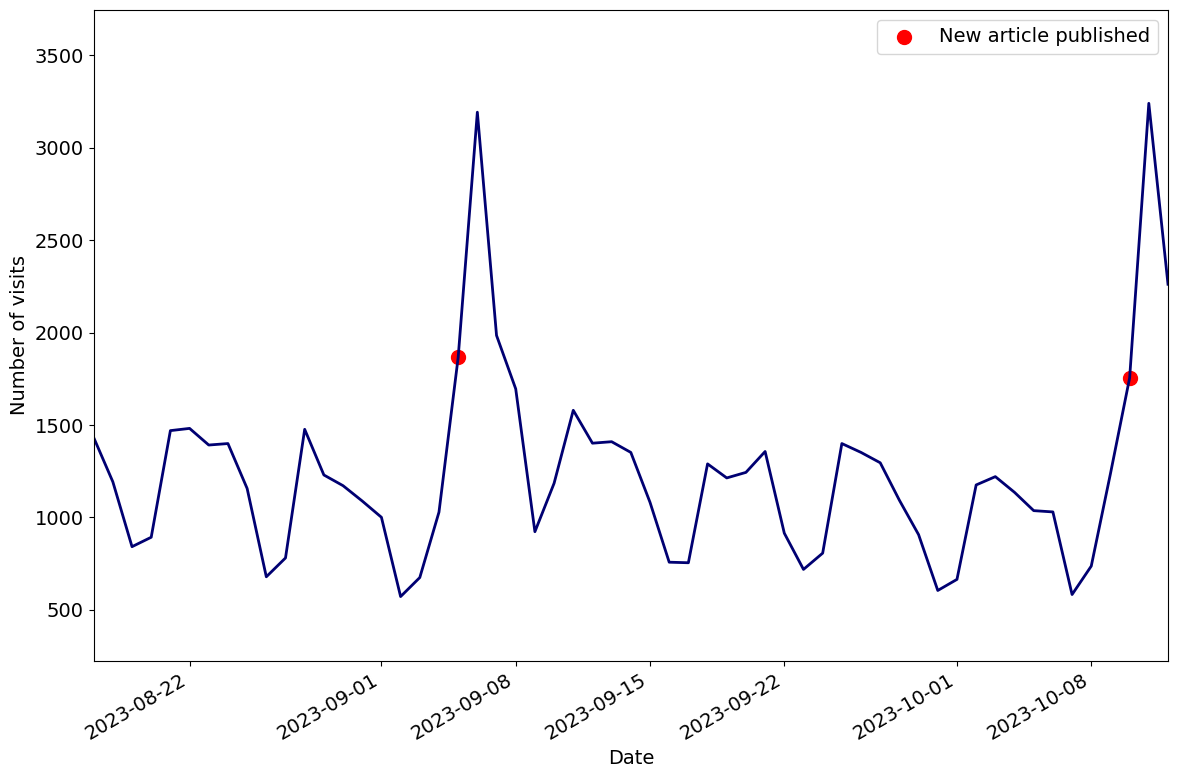

In [13]:
latest_date = df['ds'].max()
start_date = latest_date - pd.Timedelta(days=56)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', s=100, color='#ff0000', label='New article published')
ax.set_xlabel('Date')
ax.set_ylabel('Number of visits')
ax.set_xlim([start_date, latest_date])
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH010_F02_peixeiro2.png", dpi=300)
plt.savefig('figures/CH10_F02_peixeiro2.pdf', format='pdf', bbox_inches='tight')

In [14]:
HORIZON = 7
N_WINDOWS = 20
TEST_SIZE = N_WINDOWS * HORIZON
FREQ = "D"

## Baseline model

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

In [8]:
baseline_model = SeasonalNaive(season_length=7)
sf = StatsForecast(models=[baseline_model], freq=FREQ)
init = time()
baseline_cv_fcsts = sf.cross_validation(
    h=HORIZON,
    df=df,
    n_windows=N_WINDOWS,
    step_size=HORIZON
)
print(f"Baseline time: {time() - init} seconds")
baseline_cv_fcsts.to_csv("baseline_preds.csv", header=True, index=False)

Baseline time: 0.0750117301940918 seconds


## AutoARIMA model

In [18]:
from statsforecast.arima import ARIMASummary
from statsforecast.models import AutoARIMA

In [19]:
autoarima_model = AutoARIMA(season_length=7)
sf = StatsForecast(models=[autoarima_model], freq=FREQ)
init = time()
autoarima_cv_fcsts = sf.cross_validation(
    h=HORIZON,
    df=df,
    n_windows=N_WINDOWS,
    step_size=HORIZON
)
print(f"AutoARIMA time: {time() - init} seconds")
autoarima_cv_fcsts.to_csv("autoarima_preds.csv", header=True, index=False)

AutoARIMA time: 223.22068238258362 seconds


In [20]:
sf.fit(df=df[:-TEST_SIZE])
print(ARIMASummary(sf.fitted_[0, 0].model_))

Regression with ARIMA(2,0,1)(0,1,1)[7] errors


## TimeGPT

In [9]:
from dotenv import load_dotenv
from nixtla import NixtlaClient

In [10]:
load_dotenv()
nixtla_client = NixtlaClient()

In [35]:
init = time()
timegpt_cv_fcsts = nixtla_client.cross_validation(
    df=df,
    h=HORIZON,
    n_windows=N_WINDOWS,
    finetune_steps=50,
    finetune_loss="mae"
)
print(f"TimeGPT time: {time() - init} seconds")
timegpt_cv_fcsts.to_csv("timegpt_preds.csv", header=True, index=False)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['published', 'is_holiday']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


TimeGPT time: 51.662102937698364 seconds


## Chronos

In [15]:
import torch
from chronos import ChronosPipeline

In [16]:
def cross_validation_chronos(df, h, n_windows, target_col):
    lows = []
    medians = []
    highs = []
    for i in range(n_windows, 0, -1):
        context = torch.tensor(df[target_col][:-(h * i)])
        predictions = pipeline.predict(
            context=context,
            prediction_length=h,
            num_samples=20,
        )
        low, median, high = np.quantile(predictions[0].numpy(), [0.1, 0.5, 0.9], axis=0)
        lows.extend(low)
        medians.extend(median)
        highs.extend(high)
    return lows, medians, highs

In [17]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [18]:
init = time()
_, medians, _ = cross_validation_chronos(
    df=df, 
    h=HORIZON, 
    n_windows=N_WINDOWS, 
    target_col='y'
)
print(f"Chronos time: {time() - init} seconds")

Chronos time: 790.965301990509 seconds


In [22]:
chronos_fcsts = df[-TEST_SIZE:].copy()
chronos_fcsts['Chronos'] = medians
chronos_fcsts.to_csv("chronos_preds.csv", header=True, index=False)

## Moirai

In [23]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [25]:
df_to_gluon = df.copy()
df_to_gluon = df_to_gluon.set_index('ds')

ds = PandasDataset.from_long_dataframe(
    df_to_gluon,
    target='y',
    item_id='unique_id',
    feat_dynamic_real=["is_holiday", "published"]
)

INFO:gluonts.dataset.pandas:Grouping data by 'unique_id'; this may take some time.


In [26]:
train, test_template = split(
    ds, offset=-TEST_SIZE
)

test_data = test_template.generate_instances(
    prediction_length=HORIZON,
    windows=N_WINDOWS,
    distance=HORIZON
)

In [31]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=HORIZON,
    context_length=1000,
    patch_size="auto",
    num_samples=20,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=32)
init = time()
moirai_fcsts = predictor.predict(test_data.input)
moirai_fcsts = list(moirai_fcsts)
print(f"Moirai time: {time() - init} seconds")

Moirai time: 18.53300666809082 seconds


In [39]:
all_samples = np.stack([forecast.samples for forecast in moirai_fcsts]) # Get all samples, shape will be (20, 20, 7)
reshaped_samples = all_samples.reshape(20, -1) # Reshape to (20, 140) - combining the 20 samples and 7 timesteps
moirai_medians = np.median(reshaped_samples, axis=0) # Get 140 predictions

moirai_fcsts_df = df[-TEST_SIZE:].copy()
moirai_fcsts_df['Moirai'] = moirai_medians
moirai_fcsts_df.to_csv("moirai_preds.csv", header=True, index=False)

## TimesFM
*Note that the results of TimesFM were obtained in Google Colab.*

In [ ]:
import timesfm

In [ ]:
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu", 
        per_core_batch_size=32,
        horizon_len=HORIZON,
        num_layers=50,
        use_positional_embedding=False,
        context_len=2048,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

In [ ]:
def cross_validation_timesfm(df, h, n_windows, target_col, freq):
  all_preds = []
  for i in range(n_windows, 0, -1):
    input_df = df.iloc[:-(h*i)]
    preds_df = tfm.forecast_on_df(
        inputs=input_df,
        freq=freq,
        value_name=target_col,
        num_jobs=-1
    )
    all_preds.append(preds_df)
  preds = pd.concat(all_preds, axis=0, ignore_index=True)
  return preds

In [ ]:
init = time()
timesfm_cv_fcsts = cross_validation_timesfm(
    df=df,
    h=HORIZON,
    n_windows=N_WINDOWS,
    target_col="y",
    freq=FREQ
)
print(f"TimesFM time: {time() - init}")
# TimesFM time: 765.5753185749054

## Time-LLM

In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM
from neuralforecast.losses.pytorch import MAE

2025-02-13 10:12:41,545	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-13 10:12:42,452	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
prompt_prefix = """
    The dataset contains information on daily visits to a blog's website.
    There is a weekly seasonality as more people visit the website during weekdays, and
    there are less visitors during the weekend.
"""

timellm = TimeLLM(
    h=HORIZON,
    input_size=2*HORIZON,
    d_llm=768,
    prompt_prefix=prompt_prefix,
    batch_size=16,
    windows_batch_size=16,
    max_steps=150
)

nf = NeuralForecast(
    models=[timellm],
    freq=FREQ
)

Seed set to 1


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


In [7]:
init = time()
timellm_cv_fcsts = nf.cross_validation(
    df=df,
    n_windows=N_WINDOWS,
    step_size=HORIZON,
    refit=False,
)
print(f"Time-LLM time: {time() - init} seconds")
timellm_cv_fcsts.to_csv("timellm_preds.csv", header=True, index=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: D:\DataScienceWithMarco\book2\code\FoundationModelsForTimeSeriesForecasting\CH10\lightning_logs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 903   
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total

Epoch 99: 100%|██████████████████| 1/1 [00:05<00:00,  0.18it/s, v_num=0, train_loss_step=200.0, train_loss_epoch=241.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|█████████████████| 1/1 [00:05<00:00,  0.18it/s, v_num=0, train_loss_step=164.0, train_loss_epoch=164.0]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|█████████████████| 1/1 [00:05<00:00,  0.18it/s, v_num=0, train_loss_step=164.0, train_loss_epoch=164.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.37it/s]
Time-LLM time: 841.1515698432922 seconds


## Analyze results

In [15]:
baseline_cv_fcsts = pd.read_csv("baseline_preds.csv", parse_dates=["ds"])
autoarima_cv_fcsts = pd.read_csv("autoarima_preds.csv", parse_dates=["ds"])
timegpt_cv_fcsts = pd.read_csv("timegpt_preds.csv", parse_dates=["ds"])
chronos_cv_fcsts = pd.read_csv("chronos_preds.csv", parse_dates=["ds"])
moirai_cv_fcsts = pd.read_csv("moirai_preds.csv", parse_dates=["ds"])
timesfm_cv_fcsts = pd.read_csv("timesfm_preds.csv", parse_dates=["ds"])
timellm_cv_fcsts = pd.read_csv("timellm_preds.csv", parse_dates=["ds"])

test_df = df[-TEST_SIZE:].copy()

test_df = (test_df[["unique_id", "ds", "y"]]
    .merge(baseline_cv_fcsts[['ds', 'SeasonalNaive']], on='ds', how='left')
    .merge(autoarima_cv_fcsts[['ds', 'AutoARIMA']], on='ds', how='left')
    .merge(timegpt_cv_fcsts[['ds', 'TimeGPT']], on='ds', how='left')
    .merge(chronos_cv_fcsts[['ds', 'Chronos']], on='ds', how='left')
    .merge(moirai_cv_fcsts[['ds', 'Moirai']], on='ds', how='left')
    .merge(timesfm_cv_fcsts[['ds', 'timesfm']], on='ds', how='left')
    .merge(timellm_cv_fcsts[['ds', 'TimeLLM']], on='ds', how='left')
)
test_df = test_df.rename(columns={"timesfm": "TimesFM"})
test_df.head()

,unique_id,ds,y,SeasonalNaive,AutoARIMA,TimeGPT,Chronos,Moirai,TimesFM,TimeLLM
0,0,2023-05-26,1198,1757.0,1339.811806,1651.7064,1317.472778,1189.4634,1241.71810,1547.0802
1,0,2023-05-27,679,939.0,834.928052,944.5066,833.744202,1003.4564,775.48020,1590.4028
2,0,2023-05-28,867,1029.0,1001.218214,1046.6423,935.995758,1024.6351,912.79443,1179.1183
3,0,2023-05-29,1297,1761.0,1531.177309,1737.9320,1498.379395,1185.4161,1520.94530,1607.0531
4,0,2023-05-30,1525,1667.0,1594.674907,1673.3782,1510.177368,1481.6665,1523.13530,1746.9167


In [16]:
forecast_cols = [col for col in test_df.columns if col not in ["unique_id", "ds", "y"]]
test_df[forecast_cols] = test_df[forecast_cols].astype(int)
test_df.head()

,unique_id,ds,y,SeasonalNaive,AutoARIMA,TimeGPT,Chronos,Moirai,TimesFM,TimeLLM
0,0,2023-05-26,1198,1757,1339,1651,1317,1189,1241,1547
1,0,2023-05-27,679,939,834,944,833,1003,775,1590
2,0,2023-05-28,867,1029,1001,1046,935,1024,912,1179
3,0,2023-05-29,1297,1761,1531,1737,1498,1185,1520,1607
4,0,2023-05-30,1525,1667,1594,1673,1510,1481,1523,1746


In [17]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
)
evaluation

,unique_id,metric,SeasonalNaive,AutoARIMA,TimeGPT,Chronos,Moirai,TimesFM,TimeLLM
0,0,mae,325.371429,258.757143,300.485714,239.492857,328.078571,230.442857,343.664286
1,0,smape,0.105264,0.083882,0.097996,0.077950,0.118197,0.073499,0.119054


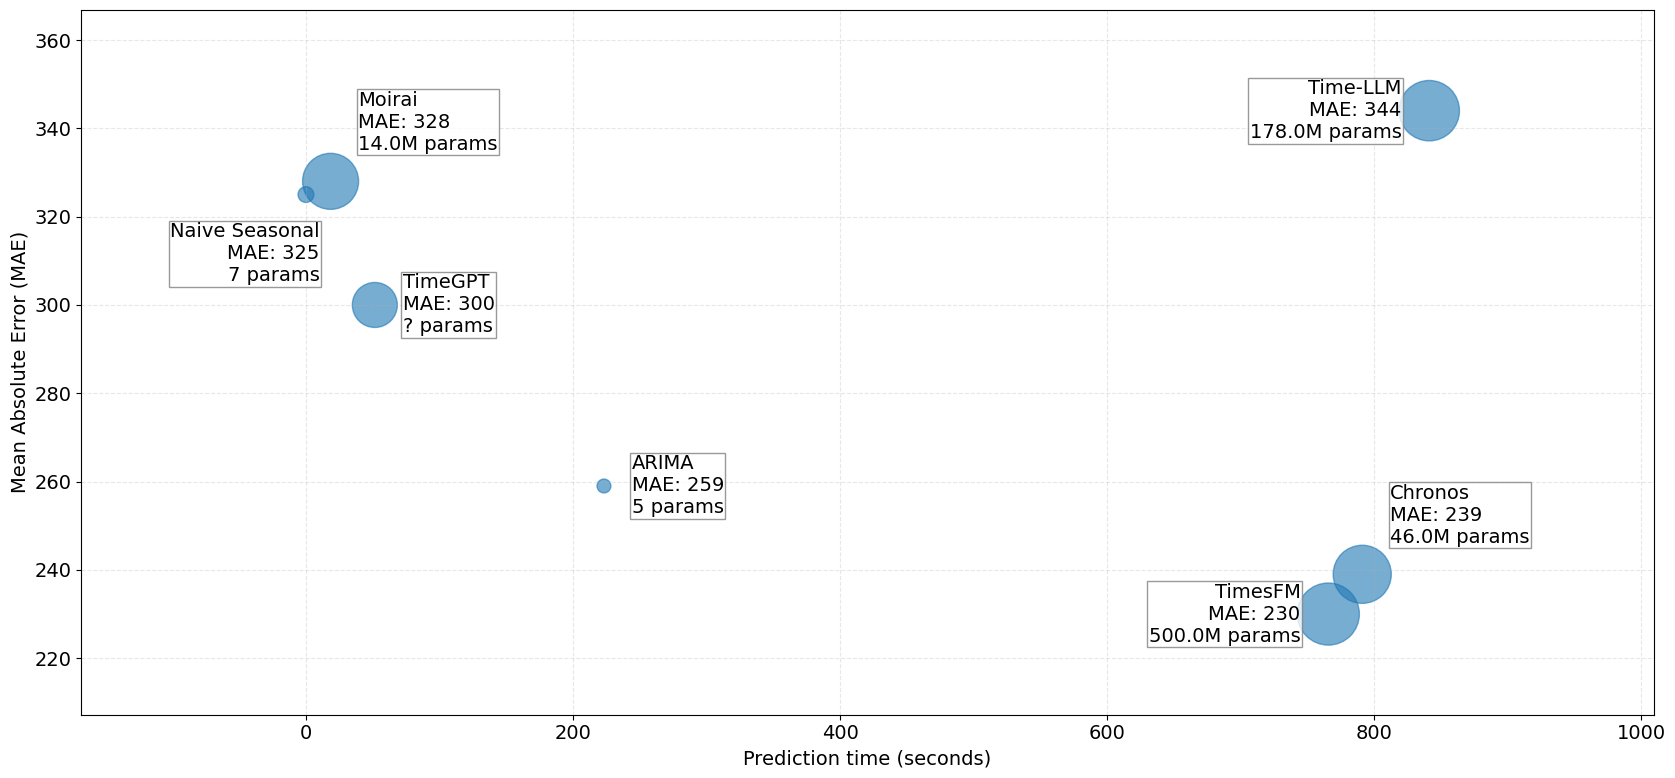

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(model_names, maes, prediction_times, param_counts):
    fig, ax = plt.subplots(figsize=(17, 8))
    
    min_size = 100
    max_size = 2000
    default_size = (min_size + max_size) / 2
    
    sizes = []
    for param in param_counts:
        if param == "?":
            sizes.append(default_size)
        else:
            size = np.log10(param + 1)
            known_params = [p for p in param_counts if p != "?"]
            size = min_size + (size - np.log10(min(known_params) + 1)) * \
                   (max_size - min_size) / (np.log10(max(known_params) + 1) - np.log10(min(known_params) + 1))
            sizes.append(size)
    
    sizes = np.array(sizes)
    
    scatter = ax.scatter(prediction_times, maes, s=sizes, alpha=0.6)
    
    for i, model in enumerate(model_names):
        if param_counts[i] == "?":
            param_str = "? params"
        elif param_counts[i] < 100:
            param_str = f"{param_counts[i]:.0f} params"
        elif param_counts[i] < 1e6:
            param_str = f"{param_counts[i]/1e3:.1f}K params"
        else:
            param_str = f"{param_counts[i]/1e6:.1f}M params"
            
        label = f"{model}\nMAE: {maes[i]:.0f}\n{param_str}"
        
        ha = 'left'
        va = 'center'
        xytext = (20, 0)
        
        if model == 'Moirai':
            xytext = (20, 20)
            va = 'bottom'
        elif model == 'Naive Seasonal':
            xytext = (10, -20)
            ha = 'right'
            va = 'top'
        elif model == 'Chronos':
            xytext = (20, 20)
            va = 'bottom'
        elif model in ['TimesFM', 'Time-LLM']: 
            xytext = (-20, 0)
            ha = 'right'
            
        ax.annotate(label,
                   (prediction_times[i], maes[i]),
                   xytext=xytext,
                   textcoords='offset points',
                   bbox=dict(facecolor='white', 
                           edgecolor='gray', 
                           alpha=0.8,
                           pad=1),
                   fontsize=14, 
                   horizontalalignment=ha,
                   verticalalignment=va)
    
    ax.set_xlabel('Prediction time (seconds)')
    ax.set_ylabel('Mean Absolute Error (MAE)')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.margins(0.2)
    plt.tight_layout()
    return fig

model_names = ['Naive Seasonal', 'ARIMA', 'TimeGPT', 'Chronos', 'Moirai', 'TimesFM', 'Time-LLM']
maes = [325, 259, 300, 239, 328, 230, 344]
prediction_times = [0.08, 223.22, 51.67, 790.97, 18.53, 765.58, 841.15]
param_counts = [7, 5, "?", 46e6, 14e6, 500e6, 178e6]

fig = plot_model_comparison(model_names, maes, prediction_times, param_counts)
plt.savefig('figures/CH10_codefig03.png', dpi=300)
plt.show()

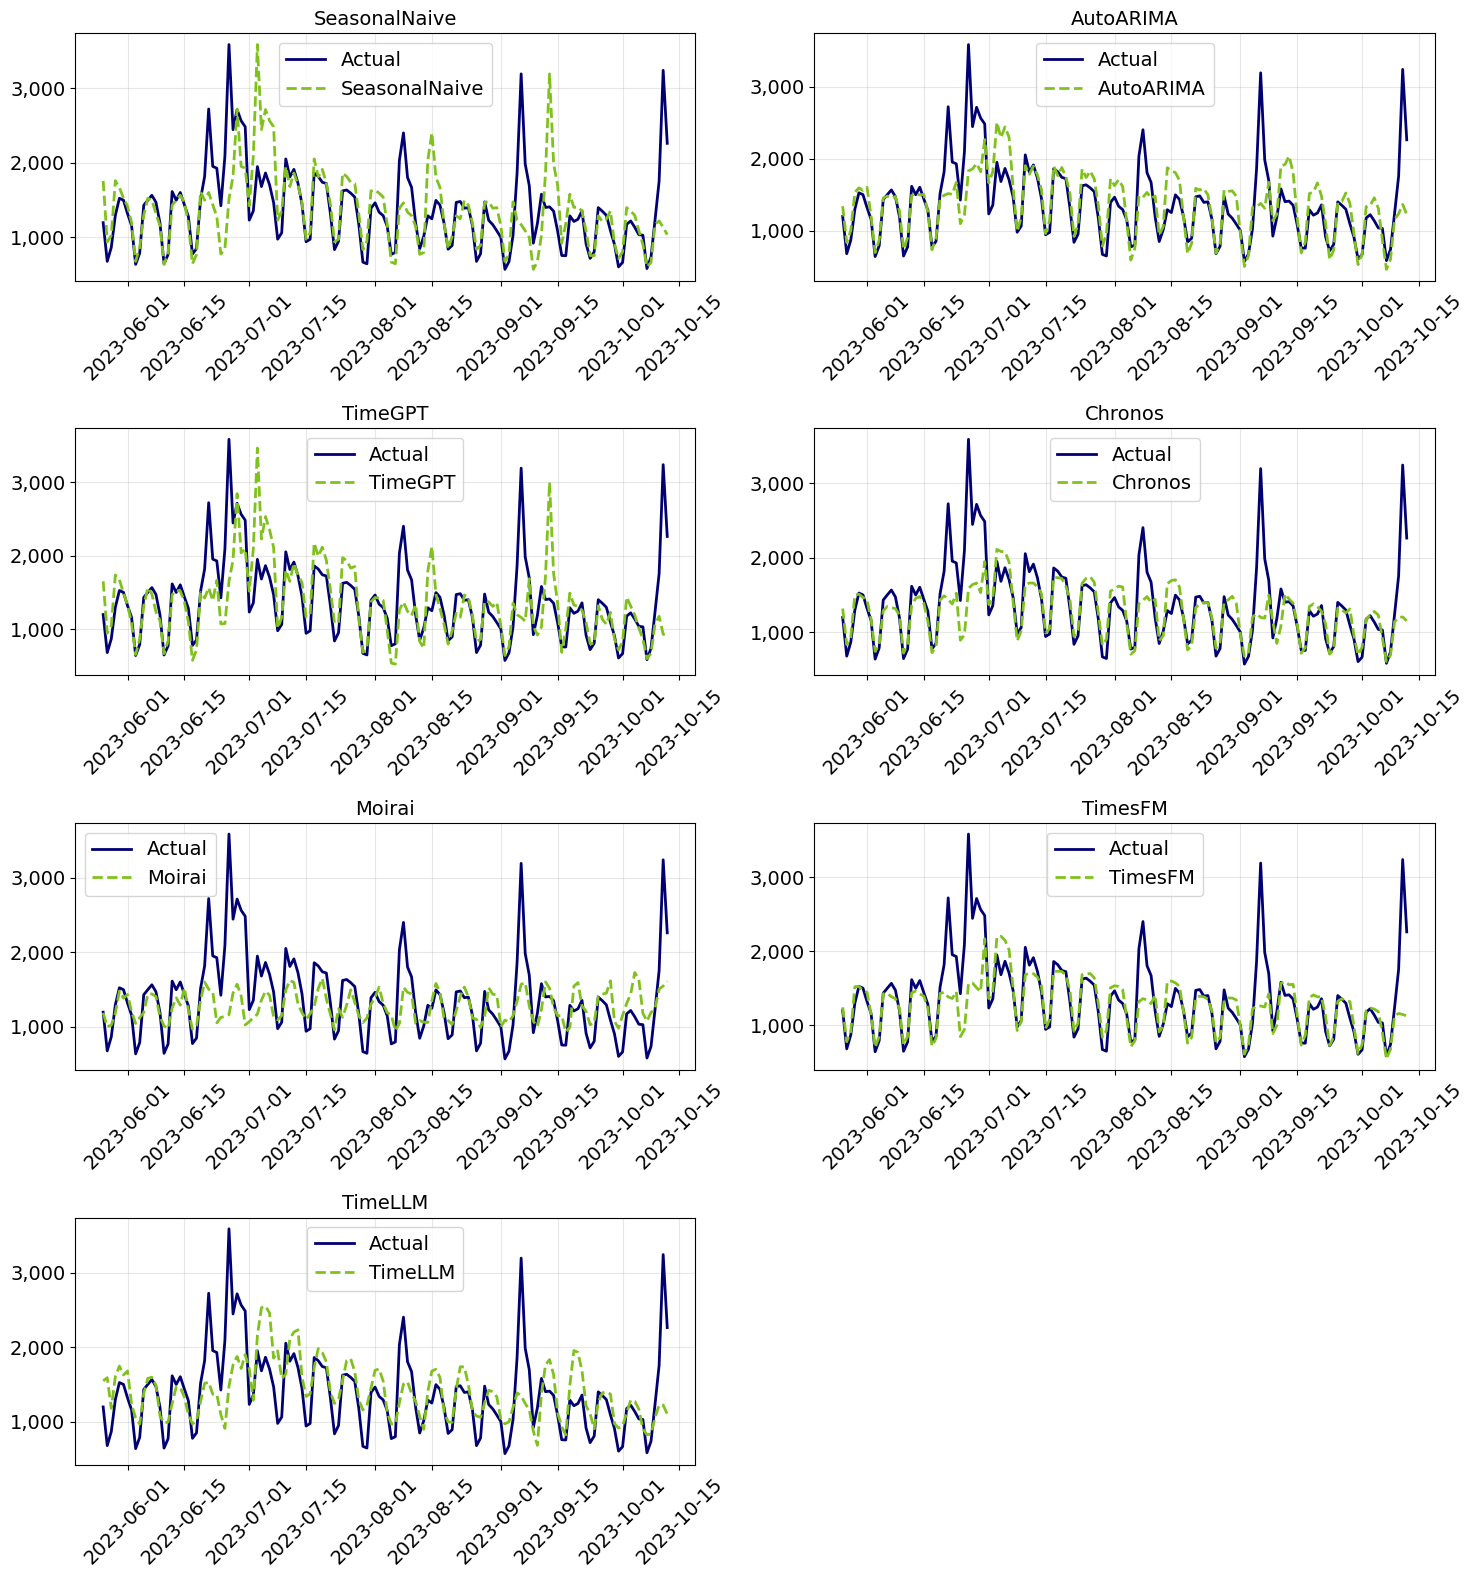

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(df, model_names):
    n_models = len(model_names)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, model in enumerate(model_names):
        ax = axes[idx]
        ax.plot(df['ds'], df['y'], label='Actual', linewidth=2)
        ax.plot(df['ds'], df[model], '--', label=model, linewidth=2)
        ax.set_title(model)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig

model_names = ['SeasonalNaive', 'AutoARIMA', 'TimeGPT', 'Chronos', 'Moirai', 'TimesFM', 'TimeLLM']

fig = plot_predictions(test_df, model_names)
plt.savefig("figures/CH010_F03_peixeiro2.png", dpi=300)
plt.savefig('figures/CH10_F03_peixeiro2.pdf', format='pdf', bbox_inches='tight')
plt.show()